In [4]:
!pip install pdfplumber -q

In [5]:
!pip install ftfy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!pip install fuzzywuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pdfplumber
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from fuzzywuzzy import fuzz
from sklearn.feature_extraction.text import CountVectorizer
from scipy import stats
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from tqdm import tqdm

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [8]:
def pdf2Text(filename):
    ''' load pdf and return the text'''
    text = ''
    # open the pdf file
    with pdfplumber.open(filename) as pdfObj:
        # loop over each page
        for page in pdfObj.pages:
            # get text from the page and concat
            text += page.extract_text()
    # return all texts
    return text

In [9]:
jd = pdf2Text('/content/drive/MyDrive/Colab Notebooks/DATASET/dataset/Job description.pdf')
print(jd)

Machine Learning Engineering
13585ABC
Knowledge and Innovation
What you’ll do
You will focus on researching, building, and designing self-running artificial intelligence (AI)
systems to automate predictive models. You are responsible to design and create the AI
algorithms capable of learning and making predictions that define machine learning (ML).
Experience and qualifications
● Bachelor's or Master's degree (mention the course as per requirement)
● 0-2 years of work experience providing analytics solutions in a commercial setting
Technical expertise
Must have
● Machine Learning, Clustering, Logistic Regression, Classification
● Different libraries such as SciKit Learn, NumPy, Pandas, Matplotlib, Seaborn
● Deep learning frameworks such as Tensorflow, Keras, PyTorch and application of Neural
Networks and models. CNN, RNN, GANs
● Familiar with Natural Language Processing and associated libraries like NLTK, SpaCy,
Beautiful Soup
● PySpark, Hadoop, and Big Data Pipelines
● Data science me

In [10]:
csvData = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DATASET/dataset/train.csv')

In [11]:
csvData.shape

(90, 2)

In [12]:
csvData.columns

Index(['CandidateID', 'Match Percentage'], dtype='object')

In [13]:
csvData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CandidateID       90 non-null     object 
 1   Match Percentage  90 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.5+ KB


In [14]:
print(csvData.duplicated().sum())

0


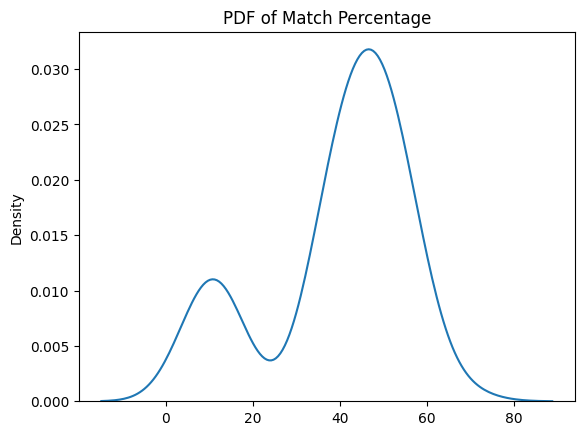

In [15]:
sns.kdeplot(csvData['Match Percentage'].values)
plt.title('PDF of Match Percentage')
plt.show()

In [16]:
for sampleResume in csvData.CandidateID.head().values:
    # load resume pdf
    print(pdf2Text('/content/drive/MyDrive/Colab Notebooks/DATASET/dataset/trainResumes/'+sampleResume+'.pdf'))
    print('\n\n'+'*'*80+'\n\n')

L I A M A N D R E W S
FRESHER
EXECUTIVE WORK EXPERIENCE
SUMMARY
DICTIS
Fresher with strong statistical and Intern Trainee, Jan 2020 to Apr 2020
analytic capabilities. Someone who
Responsible for performing and helping in decision
is driven by the passion for
making.
problem solving. Though I am from
Civil Engineering background I
have always been fascinated with
data and how Machine Learning is
evolving with iit.
PERSONAL
SKILLS
Data Analyst, Data Mining, Data
Visualization, Machine Learning,
Linear Regression, Statistical
Modeling, Predictive Modeling, SQL
ACADEMIC PROFILE
Server, Oracle, Python.
PROJECTS
B.Tech(Civil) Garodia Institute of Technosciences,
Railway Signals Determiner using
2020
relay weight system.
EXTRA-CURRICULARS
Data Preprocessing with Python
Data Visualization with Power BI


********************************************************************************


Ellie Mackey
FRESHER INTERN
Executive Profile Work Experience
Actively seeking job. An enthusiast, with a BB 

Univariate 
Univariate analysis focuses on analyzing a single variable in isolation. It helps us understand the distribution
Bi-variate Analysis
Bivariate analysis involves examining the relationship between two variables in a dataset.
By calculating correlation coefficients

In [17]:
resumeStrLen = []
resumeWordLen = []
# loop over all resumes
for sampleResume in csvData.CandidateID.values:
    # get character length of the resume
    resumeStrLen.append(len(pdf2Text('/content/drive/MyDrive/Colab Notebooks/DATASET/dataset/trainResumes/'+sampleResume+'.pdf')))
    # get word length of the resume
    resumeWordLen.append(len(pdf2Text('/content/drive/MyDrive/Colab Notebooks/DATASET/dataset/trainResumes/'+sampleResume+'.pdf').split()))

Min resume word length 73
Max resume word length 213


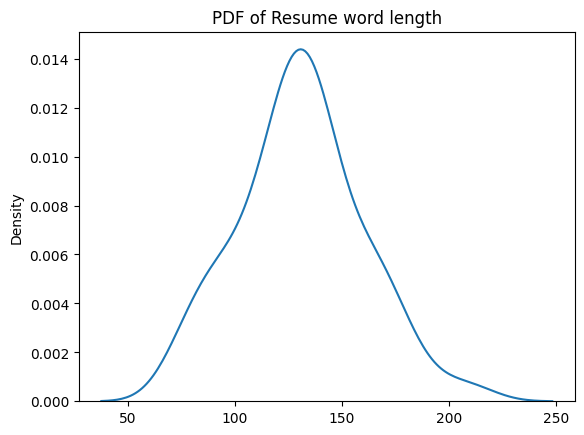

In [18]:
print('Min resume word length '+str(min(resumeWordLen)))
print('Max resume word length '+str(max(resumeWordLen)))
sns.kdeplot(resumeWordLen)
plt.title('PDF of Resume word length')
plt.show()

Spearman Rank Correlation Coefficient is 0.19467413002037587


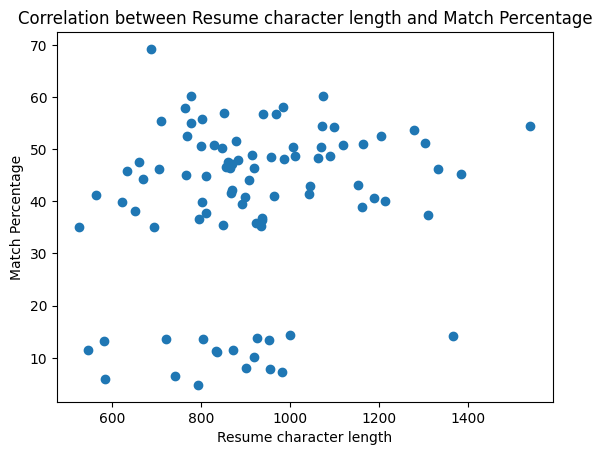

In [19]:
print('Spearman Rank Correlation Coefficient is', stats.spearmanr(resumeStrLen, csvData['Match Percentage']).correlation)
plt.scatter(resumeStrLen, csvData['Match Percentage'])
plt.title('Correlation between Resume character length and Match Percentage')
plt.xlabel('Resume character length')
plt.ylabel('Match Percentage')
plt.show()

There is very weak correlation between Resume character length and Match Percentage.
There is very weak correlation between Resume word length and Match Percentage but it is better than character length

**CLEANING THE DATA**

In [20]:
def concat(s):
    '''Concatenate words like "D A T A  S C I E N C E" to get "DATA SCIENCE"'''
    # add spaces at both end for better processing
    s = ' '+s+' '
    while True:
        # search if more than two alphabets are separated by space
        x = re.search(r"(\s[a-zA-Z]){2,}\s", s)
        if x==None:
            break
        # replace to get the concatenation
        s = s.replace(x.group(),' '+x.group().replace(' ','')+' ')
    return s

In [21]:
def preprocess_text(x, removeStopWords=False):
    # convert to lower case
    x = str(x).lower()
    # replace unusual quotes with '
    x = x.replace("′", "'").replace("’", "'")
    # replace new line with space
    x = x.replace("\n", " ")
    # concatenate
    x = concat(x)
    # remove links
    x = re.sub(r"http\S+", "", x)
    
    # convert education degrees like B.Tech or BTech to a specified form
    x = re.sub(r"\s+b[.]?[ ]?tech[(. /]{1}", " btech bachelor of technology ", x)
    x = re.sub(r"\s+m[.]?[ ]?tech[(. ]{1}", " mtech master of technology ", x)
    x = re.sub(r"\s+b[.]?[ ]?a[(. ]{1}", " ba bachelor of arts ", x)
    x = re.sub(r"\s+m[.]?[ ]?a[(. ]{1}", " ma master of arts ", x)
    x = re.sub(r"\s+b[.]?[ ]?sc[(. ]{1}", " bsc bachelor of science ", x)
    x = re.sub(r"\s+m[.]?[ ]?sc[(. ]{1}", " msc master of science ", x)
    x = re.sub(r"\s+b[.]?[ ]?e[(. ]{1}", " beng bachelor of engineering ", x)
    x = re.sub(r"\s+m[.]?[ ]?e[(. ]{1}", " meng master of engineering ", x)
    x = re.sub(r"\s+b[.]?[ ]?c[.]?[ ]?a[(. ]{1}", " bca bachelor of computer applications ", x)
    x = re.sub(r"\s+m[.]?[ ]?c[.]?[ ]?a[(. ]{1}", " mca master of computer applications ", x)
    x = re.sub(r"\s+b[.]?[ ]?b[.]?[ ]?a[(. ]{1}", " bba bachelor of business administration ", x)
    x = re.sub(r"\s+m[.]?[ ]?b[.]?[ ]?a[(. ]{1}", " mba master of business administration ", x)
    
    # convert skills with special symbols to words
    x = x.replace("c++", "cplusplus")
    x = x.replace("c#", "csharp")
    x = x.replace(".net", "dotnet")
    
    # replace non alpha numeric character with space
    x = re.sub('\W', ' ', x)
    
    # if remove stop words flag set then remove them
    z = []
    for i in x.split():
        if not (removeStopWords and i in stopwords.words('english')):
            # use lemmatizer to reduce the inflections
            lemmatizer = WordNetLemmatizer()
            i = lemmatizer.lemmatize(i)
            z.append(i)
    z = ' '.join(z)
    
    # strip white spaces
    z = z.strip()
    return z

In [22]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

True

In [23]:
jd_processed = preprocess_text(jd, removeStopWords=True)
print(jd_processed)

machine learning engineering 13585abc knowledge innovation focus researching building designing self running artificial intelligence ai system automate predictive model responsible design create ai algorithm capable learning making prediction define machine learning ml experience qualification bachelor master degree mention course per requirement 0 2 year work experience providing analytics solution commercial setting technical expertise must machine learning clustering logistic regression classification different library scikit learn numpy panda matplotlib seaborn deep learning framework tensorflow kera pytorch application neural network model cnn rnn gans familiar natural language processing associated library like nltk spacy beautiful soup pyspark hadoop big data pipeline data science methodology exploratory data analysis feature engineering model selection deployment model scale model evaluation deploying nlp architecture computer vision model production considered plus transformer

In [24]:
resumes = []
for candidateID in csvData.CandidateID.values:
    # load resume pdf
    resume = pdf2Text('/content/drive/MyDrive/Colab Notebooks/DATASET/dataset/trainResumes/'+candidateID+'.pdf')
    # preprocess
    resume_processed = preprocess_text(resume, removeStopWords=True)
    resumes.append(resume_processed)

In [25]:
for i in range(5):
    print(resumes[i])
    print('\n\n'+'*'*80+'\n\n')

liamandrews fresher executive work experience summary dictis fresher strong statistical intern trainee jan 2020 apr 2020 analytic capability someone responsible performing helping decision driven passion making problem solving though civil engineering background always fascinated data machine learning evolving iit personal skill data analyst data mining data visualization machine learning linear regression statistical modeling predictive modeling sql academic profile server oracle python project btech bachelor technology civil garodia institute technosciences railway signal determiner using 2020 relay weight system extra curriculars data preprocessing python data visualization power bi


********************************************************************************


ellie mackey fresher intern executive profile work experience actively seeking job enthusiast bb house developer master degree electronics intern trainee nov 2019 feb 2020 telecommunication keen learn eagerly looking opp

In [26]:
data = pd.DataFrame({'job_description': [jd_processed]*len(csvData), 'processed_resume': resumes, 'match_percentage': csvData['Match Percentage']})


In [27]:
print(data.head())

                                     job_description  \
0  machine learning engineering 13585abc knowledg...   
1  machine learning engineering 13585abc knowledg...   
2  machine learning engineering 13585abc knowledg...   
3  machine learning engineering 13585abc knowledg...   
4  machine learning engineering 13585abc knowledg...   

                                    processed_resume  match_percentage  
0  liamandrews fresher executive work experience ...             13.60  
1  ellie mackey fresher intern executive profile ...             36.63  
2  felix winston fresher fresher knowledge machin...             54.93  
3  jimmy gartner da tamanager professional profil...             41.46  
4  mason quadrado associate analyst certified dat...             48.91  


In [28]:
reputed_colleges = ['bits', 'iit', 'bhu', 'nit', 'vit', 'anna', 'jadavpur', 'tiet', 'thapar', 'iisc', 'srm', 'dtu', 'iiit']

# check if is from reputed college
def is_from_reputed_college(x):
    x = x.split()
    for i in reputed_colleges:
        if i in x:
            return 1
    return 0

In [29]:
def feature_extract(data):
    '''extract features'''
    # number of words in resume
    data['resume_word_num'] = data.processed_resume.apply(lambda x: len(x.split()))
    # number of unique words in job description and resumes 
    data['total_unique_word_num'] = data.apply(lambda x: len(set(x.job_description.split()).union(set(x.processed_resume.split()))) ,axis=1)
    # number of common words in job description and resumes
    data['common_word_num'] = data.apply(lambda x: len(set(x.job_description.split()).intersection(set(x.processed_resume.split()))) ,axis=1)
    # number of common words divided by total number of unique words combined in both job description and resumes
    data['common_word_ratio'] = data['common_word_num'] / data.apply(lambda x: len(set(x.job_description.split()).union(set(x.processed_resume.split()))) ,axis=1)
    # number of common words divided by minimum number of unique words between job description and resumes
    data['common_word_ratio_min'] = data['common_word_num'] / data.apply(lambda x: min(len(set(x.job_description.split())), len(set(x.processed_resume.split()))) ,axis=1) 
    # number of common words divided by maximum number of unique words between job description and resumes
    data['common_word_ratio_max'] = data['common_word_num'] / data.apply(lambda x: max(len(set(x.job_description.split())), len(set(x.processed_resume.split()))) ,axis=1) 
    
    # Fuzz WRatio
    data["fuzz_ratio"] = data.apply(lambda x: fuzz.WRatio(x.job_description, x.processed_resume), axis=1)
    # Fuzz partial ratio
    data["fuzz_partial_ratio"] = data.apply(lambda x: fuzz.partial_ratio(x.job_description, x.processed_resume), axis=1)
    # Fuzz token set ratio
    data["fuzz_token_set_ratio"] = data.apply(lambda x: fuzz.token_set_ratio(x.job_description, x.processed_resume), axis=1)
    # Fuzz token sort ratio
    data["fuzz_token_sort_ratio"] = data.apply(lambda x: fuzz.token_sort_ratio(x.job_description, x.processed_resume), axis=1)
    
    # is fresher
    data['is_fresher'] = data.processed_resume.apply(lambda x: int('fresher' in x.split()))
    # from reputed college
    data['from_reputed_college'] = data.processed_resume.apply(lambda x: is_from_reputed_college(x))
    
    # fill na fields with 0
    data.fillna(0, inplace=True)
    return data

In [30]:
data_feature = feature_extract(data)

In [31]:
data_feature.head()

,job_description,processed_resume,match_percentage,resume_word_num,total_unique_word_num,common_word_num,common_word_ratio,common_word_ratio_min,common_word_ratio_max,fuzz_ratio,fuzz_partial_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,is_fresher,from_reputed_college
0,machine learning engineering 13585abc knowledg...,liamandrews fresher executive work experience ...,13.60,86,191,13,0.068063,0.183099,0.097744,86,2,32,1,1,1
1,machine learning engineering 13585abc knowledg...,ellie mackey fresher intern executive profile ...,36.63,84,180,27,0.150000,0.364865,0.203008,86,13,55,3,1,0
2,machine learning engineering 13585abc knowledg...,felix winston fresher fresher knowledge machin...,54.93,93,184,18,0.097826,0.260870,0.135338,86,2,43,3,1,0
3,machine learning engineering 13585abc knowledg...,jimmy gartner da tamanager professional profil...,41.46,117,209,21,0.100478,0.216495,0.157895,29,16,31,2,0,0
4,machine learning engineering 13585abc knowledg...,mason quadrado associate analyst certified dat...,48.91,104,196,22,0.112245,0.258824,0.165414,86,15,41,1,0,0


Univariate Analysis

Min = 63
Max = 168
Mean = 102.17777777777778


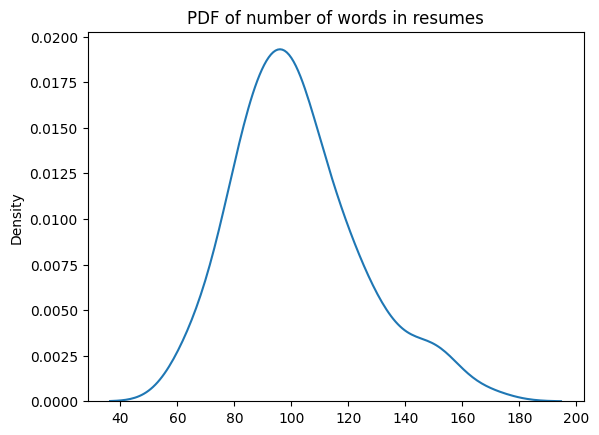

In [32]:
temp = np.array(data_feature['resume_word_num'])
print('Min = '+str(np.min(temp)))
print('Max = '+str(np.max(temp)))
print('Mean = '+str(np.mean(temp)))
sns.kdeplot(temp)
plt.title('PDF of number of words in resumes')
plt.show()

Min = 171
Max = 227
Mean = 193.8


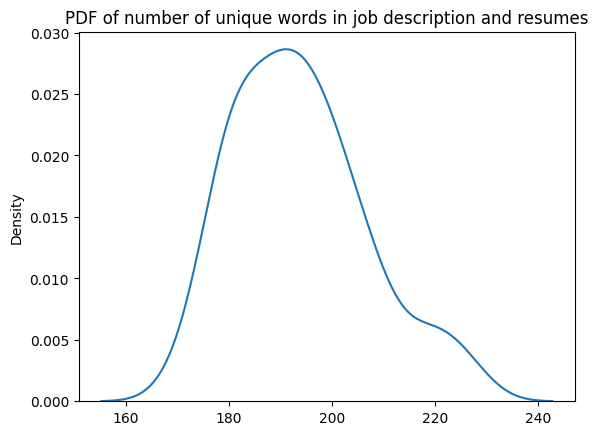

In [33]:
temp = np.array(data_feature['total_unique_word_num'])
print('Min = '+str(np.min(temp)))
print('Max = '+str(np.max(temp)))
print('Mean = '+str(np.mean(temp)))
sns.kdeplot(temp)
plt.title('PDF of number of unique words in job description and resumes')
plt.show()

Spearman Rank Correlation Coefficient is 0.2759533774129115


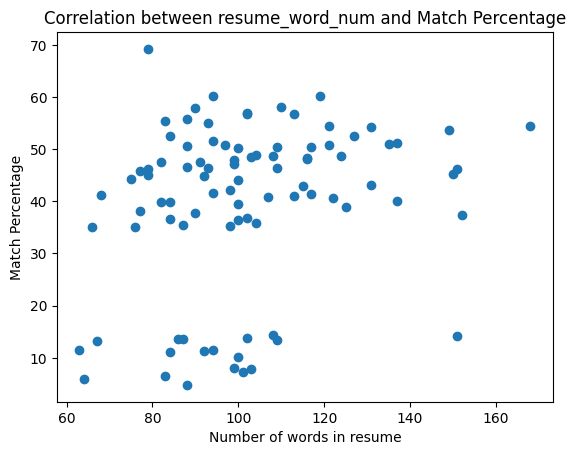

In [34]:
print('Spearman Rank Correlation Coefficient is', stats.spearmanr(data_feature['resume_word_num'], data_feature['match_percentage']).correlation)
plt.scatter(data_feature['resume_word_num'], data_feature['match_percentage'])
plt.title('Correlation between resume_word_num and Match Percentage')
plt.xlabel('Number of words in resume')
plt.ylabel('Match Percentage')
plt.show()

Spearman Rank Correlation Coefficient is -0.015769599975427144


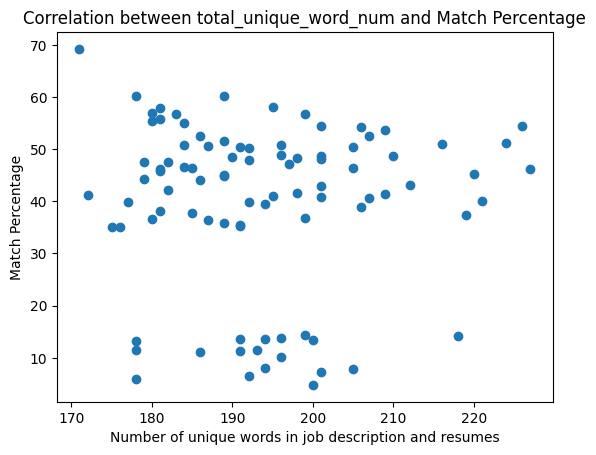

In [35]:
print('Spearman Rank Correlation Coefficient is', stats.spearmanr(data_feature['total_unique_word_num'], data_feature['match_percentage']).correlation)
plt.scatter(data_feature['total_unique_word_num'], data_feature['match_percentage'])
plt.title('Correlation between total_unique_word_num and Match Percentage')
plt.xlabel('Number of unique words in job description and resumes')
plt.ylabel('Match Percentage')
plt.show()

In [36]:
vectorizer = CountVectorizer(ngram_range=(1,3), min_df=4, max_df=.99, binary=True)

In [37]:
vocab_text = np.unique(np.append(data_feature.processed_resume.values, data_feature.job_description.values))

In [38]:
vectorizer.fit(vocab_text)

CountVectorizer(binary=True, max_df=0.99, min_df=4, ngram_range=(1, 3))

In [39]:
print(len(vectorizer.vocabulary_))

712


In [40]:
bow_vocab = np.array(list(vectorizer.vocabulary_.keys()))

In [41]:
with open('bow_vocab.npy', 'wb') as f:
    np.save(f, bow_vocab, allow_pickle=True)

In [42]:
bow_resume = vectorizer.transform(data_feature.processed_resume.values).toarray()
print(bow_resume.shape)

(90, 712)


In [43]:
with open('bow_resume.npy', 'wb') as f:
    np.save(f, bow_resume, allow_pickle=True)
bow_jd = vectorizer.transform(data_feature.job_description.values).toarray()
print(bow_jd.shape)

(90, 712)


In [44]:
with open('bow_jd.npy', 'wb') as f:
    np.save(f, bow_jd, allow_pickle=True)

In [45]:
def cosine_euclidean(u, v):
    return np.array([np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v)), np.linalg.norm(u - v)])
cosine_euclidean_data = np.array([cosine_euclidean(bow_jd[i], bow_resume[i]) for i in range(len(bow_resume))])
data_feature[["cosine_similarity", "euclidean_distance"]] = cosine_euclidean_data

In [46]:
cosine_euclidean_data = np.array([cosine_euclidean(bow_jd[i], bow_resume[i]) for i in range(len(bow_resume))])

In [47]:
data_feature[["cosine_similarity", "euclidean_distance"]] = cosine_euclidean_data

In [48]:
data_feature.to_csv('data_feature.csv', index=False)

In [49]:
data_feature2 = data_feature.drop(columns=['cosine_similarity', 'euclidean_distance'])

In [50]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse, r2_score, mean_absolute_error as mae
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import warnings
from joblib import dump, load
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from prettytable import PrettyTable
from sklearn.preprocessing import MinMaxScaler

In [51]:
csvData = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DATASET/dataset/train.csv')

In [52]:
data_feature = pd.read_csv('data_feature.csv')

In [53]:
data_feature.head()

,job_description,processed_resume,match_percentage,resume_word_num,total_unique_word_num,common_word_num,common_word_ratio,common_word_ratio_min,common_word_ratio_max,fuzz_ratio,fuzz_partial_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,is_fresher,from_reputed_college,cosine_similarity,euclidean_distance
0,machine learning engineering 13585abc knowledg...,liamandrews fresher executive work experience ...,13.60,86,191,13,0.068063,0.183099,0.097744,86,2,32,1,1,1,0.136678,13.416408
1,machine learning engineering 13585abc knowledg...,ellie mackey fresher intern executive profile ...,36.63,84,180,27,0.150000,0.364865,0.203008,86,13,55,3,1,0,0.318471,12.288206
2,machine learning engineering 13585abc knowledg...,felix winston fresher fresher knowledge machin...,54.93,93,184,18,0.097826,0.260870,0.135338,86,2,43,3,1,0,0.241508,12.845233
3,machine learning engineering 13585abc knowledg...,jimmy gartner da tamanager professional profil...,41.46,117,209,21,0.100478,0.216495,0.157895,29,16,31,2,0,0,0.201306,13.527749
4,machine learning engineering 13585abc knowledg...,mason quadrado associate analyst certified dat...,48.91,104,196,22,0.112245,0.258824,0.165414,86,15,41,1,0,0,0.266333,12.884099


In [54]:
with open('bow_resume.npy', 'rb') as f:
    bow_resume = np.load(f, allow_pickle=True)

In [55]:
with open('bow_jd.npy', 'rb') as f:
    bow_jd = np.load(f, allow_pickle=True)

In [56]:
y_bow = data_feature.match_percentage

In [57]:
X_bow_1 = data_feature.drop(columns=['job_description', 'processed_resume', 'match_percentage'])

In [58]:
X_bow_1.head(3)

,resume_word_num,total_unique_word_num,common_word_num,common_word_ratio,common_word_ratio_min,common_word_ratio_max,fuzz_ratio,fuzz_partial_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,is_fresher,from_reputed_college,cosine_similarity,euclidean_distance
0,86,191,13,0.068063,0.183099,0.097744,86,2,32,1,1,1,0.136678,13.416408
1,84,180,27,0.150000,0.364865,0.203008,86,13,55,3,1,0,0.318471,12.288206
2,93,184,18,0.097826,0.260870,0.135338,86,2,43,3,1,0,0.241508,12.845233


In [59]:
X_bow_2 = pd.DataFrame(bow_jd, columns=['bow_jd_'+str(i) for i in range(1, bow_jd.shape[1]+1)])

In [60]:
X_bow_2.head(3)

,bow_jd_1,bow_jd_2,bow_jd_3,bow_jd_4,bow_jd_5,bow_jd_6,bow_jd_7,bow_jd_8,bow_jd_9,bow_jd_10,...,bow_jd_703,bow_jd_704,bow_jd_705,bow_jd_706,bow_jd_707,bow_jd_708,bow_jd_709,bow_jd_710,bow_jd_711,bow_jd_712
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [61]:
X_bow_3 = pd.DataFrame(bow_resume, columns=['bow_resume_'+str(i) for i in range(1, bow_resume.shape[1]+1)])

In [62]:
X_bow_3.head(3)

,bow_resume_1,bow_resume_2,bow_resume_3,bow_resume_4,bow_resume_5,bow_resume_6,bow_resume_7,bow_resume_8,bow_resume_9,bow_resume_10,...,bow_resume_703,bow_resume_704,bow_resume_705,bow_resume_706,bow_resume_707,bow_resume_708,bow_resume_709,bow_resume_710,bow_resume_711,bow_resume_712
0,0,0,0,0,0,0,0,0,0,1,...,0,1,0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0


In [63]:
X_bow = pd.concat([X_bow_1, X_bow_2, X_bow_3], axis=1)
print(X_bow.shape)
X_bow.head(3)

(90, 1438)


,resume_word_num,total_unique_word_num,common_word_num,common_word_ratio,common_word_ratio_min,common_word_ratio_max,fuzz_ratio,fuzz_partial_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,...,bow_resume_703,bow_resume_704,bow_resume_705,bow_resume_706,bow_resume_707,bow_resume_708,bow_resume_709,bow_resume_710,bow_resume_711,bow_resume_712
0,86,191,13,0.068063,0.183099,0.097744,86,2,32,1,...,0,1,0,1,0,0,0,0,0,0
1,84,180,27,0.150000,0.364865,0.203008,86,13,55,3,...,0,1,0,0,0,0,0,0,0,0
2,93,184,18,0.097826,0.260870,0.135338,86,2,43,3,...,0,1,1,0,0,0,0,0,0,0


In [64]:
# column names
features = X_bow.columns.to_numpy()

In [65]:
y_bow = y_bow.to_numpy()
# do train test split
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X_bow, y_bow, test_size=0.30, random_state=1)
train_indices = X_train_bow.index
test_indices = X_test_bow.index


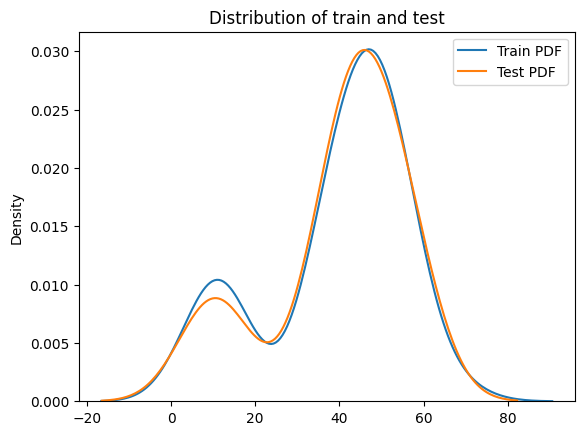

In [66]:
plt.title('Distribution of train and test')
sns.kdeplot(y_train_bow, label='Train PDF')
sns.kdeplot(y_test_bow, label='Test PDF')
plt.legend()
plt.show()

In [67]:
scaler = StandardScaler()
scaler.fit(X_train_bow)
# standardizing train data
X_train_bow = scaler.transform(X_train_bow)
# standardizing test data
X_test_bow = scaler.transform(X_test_bow)

MODEL Support Vector Regression (Linear Kernel)

In [68]:
def objective(space):
    '''objective function for hyper param tuning'''
    # 3 fold cross validation
    kf = KFold(n_splits=3)
    mselosses = []
    # k fold cross validation
    for train_index, cv_index in kf.split(X_train_bow):
        # split input data
        X_train, X_cv = X_train_bow[train_index], X_train_bow[cv_index]
        # split output data
        y_train, y_cv = y_train_bow[train_index], y_train_bow[cv_index]
        # create SVR RBF
        model = SVR(kernel = 'linear', C = space['c'])
        # train the model
        model.fit(X_train, y_train)
        cv_pred = model.predict(X_cv)
        tempmseloss = mse(y_cv, cv_pred)
        mselosses.append(tempmseloss)
        
    # calculate mse
    mseloss = sum(mselosses)/len(mselosses)
    # return params
    return {'loss':mseloss, 'status': STATUS_OK, 'params': space }

In [69]:
space = {
    # uniform distribution between 0.001 and 1000
    "c": hp.quniform("c", 0.001, 1000, 0.001)
}

In [70]:
trials = Trials()
# minimise the objective function with max 300 trials
best_param = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=300,
            trials=trials)

100%|██████████| 300/300 [00:07<00:00, 41.32trial/s, best loss: 167.43628624148707]


In [71]:
print("Best Param : ", best_param)

Best Param :  {'c': 410.41200000000003}


In [72]:
svr_model_linear = SVR(kernel = 'linear', C = 1.429)

In [73]:
svr_model_linear.fit(X_train_bow, y_train_bow)

SVR(C=1.429, kernel='linear')

In [74]:
def showErrors(model, X_train, y_train, X_test, y_test):
    '''show errors for train and test and also return test errors'''
    print('\n','==========','Train Errors','==========','\n')
    # predict for train
    y_train_pred = model.predict(X_train)
    # get mean squared error for train data
    print('MSE on train data =>',mse(y_train, y_train_pred))
    # get r squared score for train data
    print('R-squared on train data =>',r2_score(y_train, y_train_pred))
    # plot histogram 
    sns.histplot(y_train - y_train_pred)
    # set title and show plot
    plt.title('PDF of errors')
    plt.show()

    print('\n','==========','Test Errors','==========','\n')
    # predict for test
    y_test_pred = model.predict(X_test)
    # get mean squared error for test data
    print('MSE on test data =>',mse(y_test, y_test_pred))
    # get r squared score for test data
    print('R-squared on test data =>',r2_score(y_test, y_test_pred))
    # get errors
    test_errors = y_test - y_test_pred
    # plot histogram 
    sns.histplot(test_errors)
    # set title and show plot
    plt.title('PDF of errors')
    plt.show()
    return test_errors


 ========== Train Errors ========== 

MSE on train data => 0.010004223643363994
R-squared on train data => 0.9999618474846187


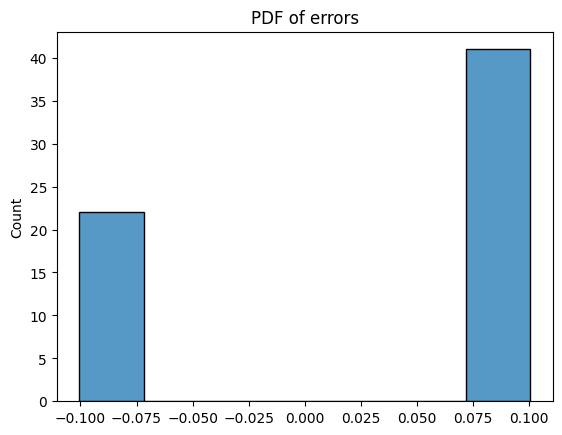


 ========== Test Errors ========== 

MSE on test data => 93.92765089883254
R-squared on test data => 0.6008714418140302


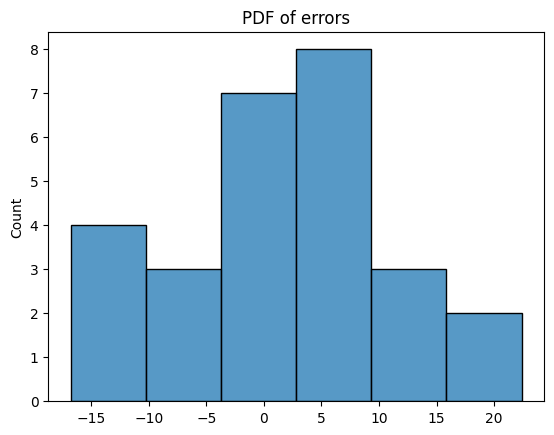

In [75]:
test_errors = showErrors(svr_model_linear, X_train_bow, y_train_bow, X_test_bow, y_test_bow)

Linear Regression

In [76]:
def objective(space):
    '''objective function for hyper param tuning'''
    # 3 fold cross validation
    kf = KFold(n_splits=3)
    mselosses = []
    # k fold cross validation
    for train_index, cv_index in kf.split(X_train_bow):
        # split input data
        X_train, X_cv = X_train_bow[train_index], X_train_bow[cv_index]
        # split output data
        y_train, y_cv = y_train_bow[train_index], y_train_bow[cv_index]
        # create Linear Regression model with l2 regularizer
        model = Ridge(alpha = space['alpha'], max_iter=3000)
        # train the model
        model.fit(X_train, y_train)
        # predict output for cv
        cv_pred = model.predict(X_cv)
        # calculate cv loss
        tempmseloss = mse(y_cv, cv_pred)
        # save cv mse loss
        mselosses.append(tempmseloss)
        
    # calculate mse
    mseloss = sum(mselosses)/len(mselosses)
    # return params
    return {'loss':mseloss, 'status': STATUS_OK, 'params': space }

In [77]:
# search space for hyper parameter tuning
space = {
    # uniform distribution between 0.001 and 1000
    "alpha": hp.quniform("alpha", 0.001, 1000, 0.001)
}

In [78]:
trials = Trials()
# minimise the objective function with max 300 trials
best_param = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=300,
            trials=trials)

100%|██████████| 300/300 [00:16<00:00, 18.55trial/s, best loss: 167.1495526214576]


In [79]:
print("Best Param : ", best_param)

Best Param :  {'alpha': 0.056}


In [80]:
lr_model = Ridge(alpha = 0.013000000000000001, max_iter=3000)
# fit model on train data
lr_model.fit(X_train_bow, y_train_bow)

Ridge(alpha=0.013000000000000001, max_iter=3000)


 ========== Train Errors ========== 

MSE on train data => 6.537574654413747e-08
R-squared on train data => 0.9999999997506804


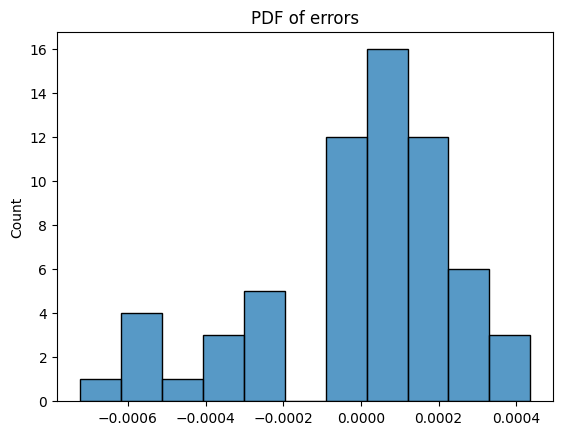


 ========== Test Errors ========== 

MSE on test data => 93.51381724016092
R-squared on test data => 0.602629953071725


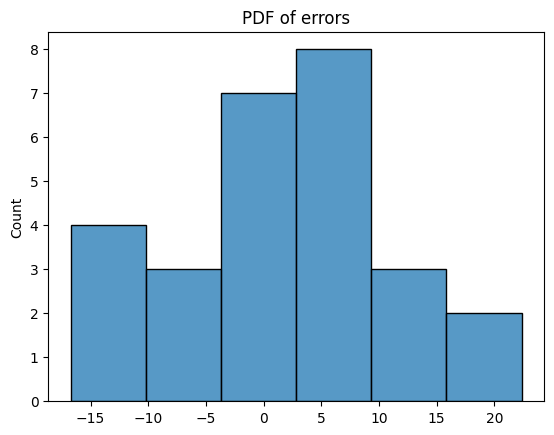

In [81]:
test_errors = showErrors(lr_model, X_train_bow, y_train_bow, X_test_bow, y_test_bow)

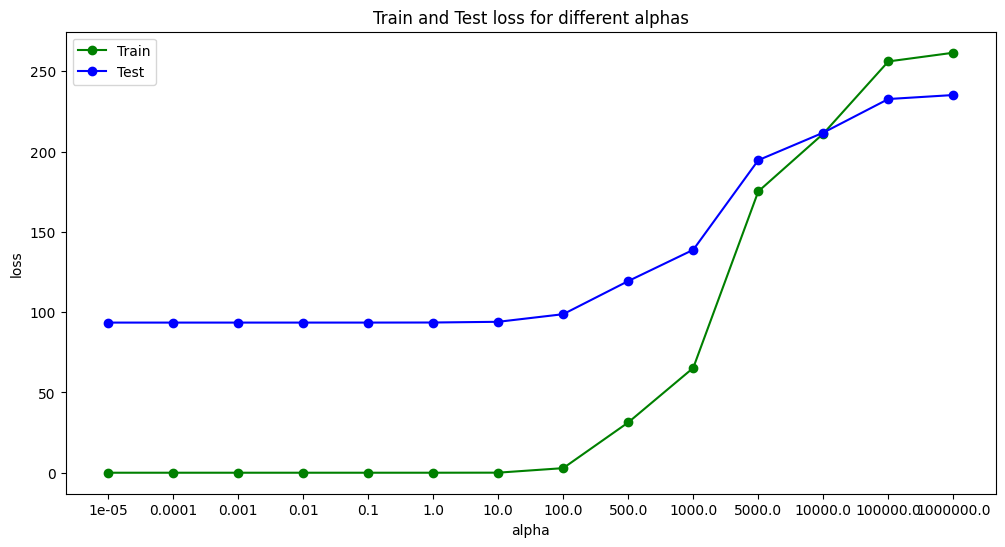

In [90]:
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, .5e3, 1e3, .5e4, 1e4, 1e5, 1e6]

train_mse = []
cv_mse = []
for i in alphas:
    # create l2 linear regerssion model
    model = Ridge(alpha = i, max_iter=3000)
    # fit model on train data
    model.fit(X_train_bow, y_train_bow)
    # get train loss
    train_mse.append(mse(y_train_bow, model.predict(X_train_bow)))
    # get test loss
    cv_mse.append(mse(y_test_bow, model.predict(X_test_bow)))

# create x axis values
x_axis = list(range(len(alphas)))
# set fig size
plt.figure(figsize=(12, 6))
# title for the plot
plt.title('Train and Test loss for different alphas')
# plot a line plot for train mse
plt.plot(train_mse, 'o-', color='green', label='Train')
# plot a line plot for cv mse
plt.plot(cv_mse, 'o-', color='blue', label='Test')
# change x ticks
plt.xticks(ticks=x_axis, labels=alphas)
plt.xlabel('alpha')
plt.ylabel('loss')
plt.legend()
plt.show()

In [91]:
csvData.loc[test_indices[np.abs(test_errors)>15]]

,CandidateID,Match Percentage
87,candidate_072,44.94
74,candidate_086,7.81
60,candidate_047,11.30
40,candidate_015,8.01
89,candidate_037,56.70


KNN regression

In [92]:
csvData = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DATASET/dataset/train.csv')

In [93]:
type(data_feature)

pandas.core.frame.DataFrame

In [94]:
data_feature.head(2)

,job_description,processed_resume,match_percentage,resume_word_num,total_unique_word_num,common_word_num,common_word_ratio,common_word_ratio_min,common_word_ratio_max,fuzz_ratio,fuzz_partial_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,is_fresher,from_reputed_college,cosine_similarity,euclidean_distance
0,machine learning engineering 13585abc knowledg...,liamandrews fresher executive work experience ...,13.60,86,191,13,0.068063,0.183099,0.097744,86,2,32,1,1,1,0.136678,13.416408
1,machine learning engineering 13585abc knowledg...,ellie mackey fresher intern executive profile ...,36.63,84,180,27,0.150000,0.364865,0.203008,86,13,55,3,1,0,0.318471,12.288206


In [95]:
w2v_model=load('/content/drive/MyDrive/Colab Notebooks/DATASET/w2v_model.joblib')

In [96]:
w2v_words = list(w2v_model.key_to_index)

In [97]:
def getAverageWord2Vec(sentence):
    ''' get Average Word2Vec given a sentence'''
    # initialize sentence_vector to zeros
    sentence_vector = np.zeros(300)
    # count words in sentence
    count_words = 0
    # loop over each word
    for word in sentence.split():
        # if there is a vector for given word
        if word in w2v_words:
            # get the vector
            vector = w2v_model[word]
            # add the vectors
            sentence_vector = sentence_vector + vector
            # increment count
            count_words = count_words + 1
    if count_words != 0:
        # if the word count is not zero then divide by it to get the average
        sentence_vector /= count_words
    # return the avg word2vec
    return sentence_vector

In [98]:
w2v_resume = []
# used tqdm to print progress bar
for sentence in tqdm(data_feature2.processed_resume.values):
    # get and append sentence vectors
    w2v_resume.append(getAverageWord2Vec(sentence))
# convert to numpy array
w2v_resume = np.array(w2v_resume)

100%|██████████| 90/90 [00:09<00:00,  9.03it/s]


In [99]:
print(w2v_resume.shape)

(90, 300)


In [100]:
with open('w2v_resume.npy', 'wb') as f:
    np.save(f, w2v_resume, allow_pickle=True)

In [101]:
w2v_jd = []
for sentence in tqdm(data_feature2.job_description.values):
    # get and append sentence vectors
    w2v_jd.append(getAverageWord2Vec(sentence))
# convert to numpy array
w2v_jd = np.array(w2v_jd)

100%|██████████| 90/90 [00:14<00:00,  6.25it/s]


In [102]:
print(w2v_jd.shape)

(90, 300)


In [103]:
# save w2v_resume to file
with open('w2v_resume.npy', 'wb') as f:
    np.save(f, w2v_resume, allow_pickle=True)

In [104]:
w2v_jd = []
for sentence in tqdm(data_feature2.job_description.values):
    # get and append sentence vectors
    w2v_jd.append(getAverageWord2Vec(sentence))
# convert to numpy array
w2v_jd = np.array(w2v_jd)

100%|██████████| 90/90 [00:14<00:00,  6.05it/s]


In [105]:
with open('w2v_jd.npy', 'wb') as f:
    np.save(f, w2v_jd, allow_pickle=True)

In [106]:
cosine_euclidean_data = np.array([cosine_euclidean(w2v_jd[i], w2v_resume[i]) for i in range(len(w2v_resume))])
data_feature2[["cosine_similarity", "euclidean_distance"]] = cosine_euclidean_data

In [107]:
data_feature2.to_csv('data_feature2.csv', index=False)

In [108]:
data_feature = pd.read_csv('/content/data_feature2.csv')

In [109]:
data_feature.head(2)

,job_description,processed_resume,match_percentage,resume_word_num,total_unique_word_num,common_word_num,common_word_ratio,common_word_ratio_min,common_word_ratio_max,fuzz_ratio,fuzz_partial_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,is_fresher,from_reputed_college,cosine_similarity,euclidean_distance
0,machine learning engineering 13585abc knowledg...,liamandrews fresher executive work experience ...,13.60,86,191,13,0.068063,0.183099,0.097744,86,2,32,1,1,1,0.894413,0.441374
1,machine learning engineering 13585abc knowledg...,ellie mackey fresher intern executive profile ...,36.63,84,180,27,0.150000,0.364865,0.203008,86,13,55,3,1,0,0.901773,0.422274


In [110]:
with open('w2v_resume.npy', 'rb') as f:
    w2v_resume = np.load(f, allow_pickle=True)

In [111]:
with open('w2v_jd.npy', 'rb') as f:
    w2v_jd = np.load(f, allow_pickle=True)

In [112]:
# create output variable
y_w2v = data_feature.match_percentage

In [113]:
y_w2v = data_feature.match_percentage

In [114]:
X_w2v_1 = data_feature.drop(columns=['job_description', 'processed_resume', 'match_percentage'])
X_w2v_1.head(3)
X_w2v_2 = pd.DataFrame(w2v_jd, columns=['w2v_jd_'+str(i) for i in range(1, w2v_jd.shape[1]+1)])
X_w2v_2.head(3)

,w2v_jd_1,w2v_jd_2,w2v_jd_3,w2v_jd_4,w2v_jd_5,w2v_jd_6,w2v_jd_7,w2v_jd_8,w2v_jd_9,w2v_jd_10,...,w2v_jd_291,w2v_jd_292,w2v_jd_293,w2v_jd_294,w2v_jd_295,w2v_jd_296,w2v_jd_297,w2v_jd_298,w2v_jd_299,w2v_jd_300
0,0.004312,0.015603,0.020006,0.078683,-0.039103,0.039506,0.065293,-0.099928,0.061366,0.03046,...,-0.134396,0.054946,-0.084404,0.014459,-0.023068,0.005727,0.041744,-0.032325,-0.01288,0.018934
1,0.004312,0.015603,0.020006,0.078683,-0.039103,0.039506,0.065293,-0.099928,0.061366,0.03046,...,-0.134396,0.054946,-0.084404,0.014459,-0.023068,0.005727,0.041744,-0.032325,-0.01288,0.018934
2,0.004312,0.015603,0.020006,0.078683,-0.039103,0.039506,0.065293,-0.099928,0.061366,0.03046,...,-0.134396,0.054946,-0.084404,0.014459,-0.023068,0.005727,0.041744,-0.032325,-0.01288,0.018934


In [115]:
X_w2v_3 = pd.DataFrame(w2v_resume, columns=['w2v_resume_'+str(i) for i in range(1, w2v_resume.shape[1]+1)])

In [116]:
X_w2v = pd.concat([X_w2v_1, X_w2v_2, X_w2v_3], axis=1)

In [117]:
y_w2v = y_w2v.to_numpy()
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, y_w2v, test_size=0.30, random_state=1)

In [118]:
train_indices = X_train_w2v.index
test_indices = X_test_w2v.index

In [119]:
with open('selected_features2.npy', 'rb') as f:
    features = np.load(f, allow_pickle=True)

In [120]:
X_w2v = X_w2v[features]

In [121]:
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, y_w2v, test_size=0.30, random_state=1)

In [127]:
scaler3.fit(X_train_w2v)
X_train_w2v = scaler3.transform(X_train_w2v)
X_test_w2v = scaler3.transform(X_test_w2v)

In [128]:
y_train_w2v.shape

(63,)

In [129]:
def objective(space):
    '''objective function for hyper param tuning'''
    # 3 fold cross validation
    kf = KFold(n_splits=3)
    mselosses = []
    # k fold cross validation
    for train_index, cv_index in kf.split(X_train_w2v):
        # split input data
        X_train, X_cv = X_train_w2v[train_index], X_train_w2v[cv_index]
        # split output data
        y_train, y_cv = y_train_w2v[train_index], y_train_w2v[cv_index]
        # create KNeighborsRegressor
        model = KNeighborsRegressor(n_neighbors=space['n_neighbors'], metric=space['metric'])
        # train the model
        model.fit(X_train, y_train)
        cv_pred = model.predict(X_cv)
        tempmseloss = mse(y_cv, cv_pred)
        mselosses.append(tempmseloss)
        
    # calculate mse
    mseloss = sum(mselosses)/len(mselosses)
    # return params
    return {'loss':mseloss, 'status': STATUS_OK, 'params': space }

In [131]:
space = {
    "n_neighbors": hp.choice("n_neighbors", [3, 5, 7]),
    "metric": hp.choice("metric", ['euclidean', 'cosine'])
}

In [132]:
from hyperopt import hp, tpe, fmin, Trials
from sklearn.model_selection import KFold

trials = Trials()
# minimise the objective function with max 300 trials
best_param = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=300,
            trials=trials)


100%|██████████| 300/300 [00:02<00:00, 127.09trial/s, best loss: 160.41720260317462]


In [133]:
print(best_param)

{'metric': 1, 'n_neighbors': 1}


In [134]:
knn_model = KNeighborsRegressor(n_neighbors=7, metric='cosine')

In [135]:
knn_model.fit(X_train_w2v, y_train_w2v)

KNeighborsRegressor(metric='cosine', n_neighbors=7)


 ========== Train Errors ========== 

MSE on train data => 83.54998671849692
R-squared on train data => 0.6813703624566436


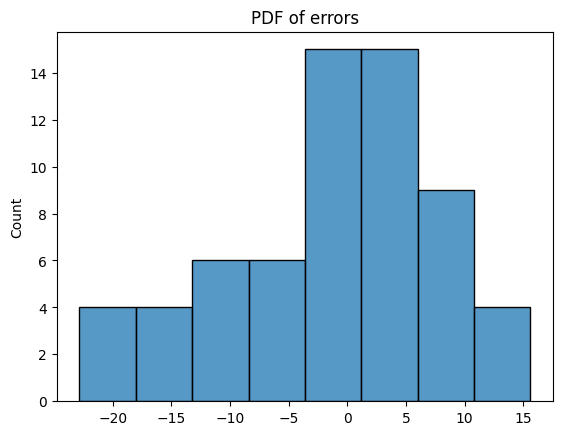


 ========== Test Errors ========== 

MSE on test data => 71.26504142101287
R-squared on test data => 0.6971721004492211


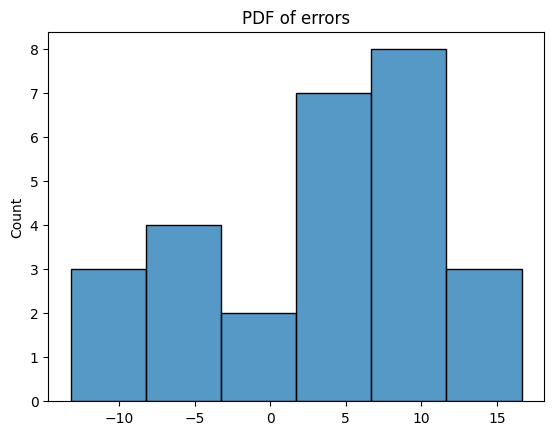

In [136]:
test_errors = showErrors(knn_model, X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

In [224]:
res= pdf2Text('/content/drive/MyDrive/Colab Notebooks/DATASET/dataset/trainResumes/candidate_015.pdf')
print(res)

John Allen
BUSINESS ANALYST
Executive Profile Work Experience
I am a business analytics fresher with a JVV IT Solutions
background in management and Business Analyst, Feb 2020 - till date
corporate analysis. I am currently looking
for an opportunity as a Data Science or Using Strategic Business Approach to enhance the quality of service
Machine Learning Engineer. between different vendors for an easier transition and product
exchanges for bigger projects.
Skills
Education
Business analyst, Data modeling, Business
intelligence, ERP implementation, html, :BBA (Management) from SP University in 2018
Requirement Gathering, Power Bi, Project MBA(Information Technology) from SP UNIVERSITY in 2020
Management.
Other Activities
Business Intelligence Contribution Award
BBA Injunction Award for Best Performer
Projects
Intelligent Liaison Methods for Future
Business and Production Ready
Environments.


In [225]:
res_processed = preprocess_text(res, removeStopWords=True)

In [226]:
data = pd.DataFrame({'job_description': [jd_processed], 'processed_resume': [res_processed]})

In [228]:
data_feature = feature_extract(data)
data_feature1 = data_feature.copy()
data_feature2 = data_feature.copy()

In [229]:
bow_resume = vectorizer.transform(data_feature.processed_resume.values).toarray()
cosine_euclidean_data = np.array([cosine_euclidean(bow_jd[i].astype(float), bow_resume[i].astype(float)) for i in range(len(bow_resume))])
data_feature1[["cosine_similarity", "euclidean_distance"]] = cosine_euclidean_data

In [230]:
res_data = pd.DataFrame({'job_description': [res_processed]*len(csvData), 'processed_resume': resumes, 'match_percentage': csvData['Match Percentage']})

In [231]:
data_feature= feature_extract(res_data)
data_feature1 = data_feature.copy()
data_feature2 = data_feature.copy()


In [232]:
bow_resume = vectorizer.transform(data_feature.processed_resume.values).toarray()

In [233]:
cosine_euclidean_data = np.array([cosine_euclidean(bow_jd[i], bow_resume[i]) for i in range(len(bow_resume))])
data_feature1[["cosine_similarity", "euclidean_distance"]] = cosine_euclidean_data

In [234]:
bow_resume = vectorizer.transform(data_feature.processed_resume.values).toarray()
    # get cosine similarity and euclidean distance features
cosine_euclidean_data = np.array([cosine_euclidean(bow_jd[i], bow_resume[i]) for i in range(len(bow_resume))])
data_feature1[["cosine_similarity", "euclidean_distance"]] = cosine_euclidean_data

In [235]:
from joblib import load
from sklearn.neighbors import DistanceMetric
import numpy as np

#jd_processed = load('/content/jd_processed.joblib')
#bow_jd = np.load('/content/bow_vocab.npy', allow_pickle=True)
#vectorizer = load('/content/vectorizer.joblib')
w2v_model = load('/content/drive/MyDrive/Colab Notebooks/DATASET/w2v_model.joblib')
with open('/content/selected_features1.npy', 'rb') as f:
    features1 = np.load(f, allow_pickle=True)

w2v_jd = load('/content/w2v_jd.joblib')

with open('/content/selected_features2.npy', 'rb') as f:
    features2 = np.load(f, allow_pickle=True)

scaler1 = load('/content/scaler1.joblib')
scaler2 = load('/content/scaler2.joblib')
svr_model_linear_1 = load('/content/svr_model_linear_1.joblib')
lr_model_2=load('/content/lr_model_2.joblib')
#lr_model_2 = load('/content/lr_model_2.joblib')


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator SVR from version 0.24.2 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator Ridge from version 0.24.2 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info

In [238]:
def getAverageWord2Vec(sentence):
    w2v_words = list(w2v_model.key_to_index)
      # initialize sentence_vector to zeros
    sentence_vector = np.zeros(300)
    # count words in sentence
    count_words = 0
    # loop over each word
    for word in sentence.split():
        # if there is a vector for given word
        if word in w2v_words:
            # get the vector
            vector = w2v_model[word]
            # add the vectors
            sentence_vector = sentence_vector + vector
            # increment count
            count_words = count_words + 1
    if count_words != 0:
        # if the word count is not zero then divide by it to get the average
        sentence_vector /= count_words
    # return the avg word2vec
    return sentence_vector

In [239]:
def cosine_euclidean(u, v):
    return np.array([np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v)), np.linalg.norm(u - v)])

In [240]:
bow_resume = vectorizer.transform(data_feature.processed_resume.values).toarray()
# get cosine similarity and euclidean distance features
cosine_euclidean_data = np.array([cosine_euclidean(bow_jd[i], bow_resume[i]) for i in range(len(bow_resume))])
data_feature1[["cosine_similarity", "euclidean_distance"]] = cosine_euclidean_data

In [241]:
X_bow_1 = data_feature1.drop(columns=['job_description', 'processed_resume'])
X_bow_2 = pd.DataFrame(bow_jd, columns=['bow_jd_'+str(i) for i in range(1, bow_jd.shape[1]+1)])
X_bow_3 = pd.DataFrame(bow_resume, columns=['bow_resume_'+str(i) for i in range(1, bow_resume.shape[1]+1)])
X_bow = pd.concat([X_bow_1, X_bow_2, X_bow_3], axis=1)

In [242]:
X_bow = X_bow[features1]

In [243]:
w2v_resume = np.array([getAverageWord2Vec(data_feature2.processed_resume.values[0])])
    # get cosine similarity and euclidean distance features
cosine_euclidean_data = np.array([cosine_euclidean(bow_jd[i], bow_resume[i]) for i in range(len(bow_resume))])
data_feature2[["cosine_similarity", "euclidean_distance"]] = cosine_euclidean_data

In [244]:
X_w2v_1 = data_feature2.drop(columns=['job_description', 'processed_resume'])
X_w2v_2 = pd.DataFrame(w2v_jd, columns=['w2v_jd_'+str(i) for i in range(1, w2v_jd.shape[1]+1)])
X_w2v_3 = pd.DataFrame(w2v_resume, columns=['w2v_resume_'+str(i) for i in range(1, w2v_resume.shape[1]+1)])
X_w2v = pd.concat([X_w2v_1, X_w2v_2, X_w2v_3], axis=1)

In [245]:
X_w2v = X_w2v[features2]

In [246]:
X_bow = scaler1.transform(X_bow)
X_w2v = scaler2.transform(X_w2v)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:434: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:434: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [247]:
X_bow[np.isnan(X_bow)] = 0
X_w2v[np.isnan(X_w2v)] = 0


In [248]:
X_ensemble = pd.DataFrame({'svr_linear_bow':svr_model_linear_1.predict(X_bow), 
                                'linear_reg_w2v':lr_model_2.predict(X_w2v)})

In [249]:
scaler3 = load('/content/scaler3.joblib')
#X_ensemble = scaler3.transform(X_ensemble)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [217]:
X_ensemble.shape

(90, 2)

In [218]:
import sklearn
print(sklearn.__version__)


1.0


In [219]:
from sklearn.neighbors import _dist_metrics

In [250]:
knn_model_meta = load('/content/knn_model_meta.joblib')

    # predict the o/p
prediction = np.round(knn_model_meta.predict(X_ensemble), 2)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator KNeighborsRegressor from version 0.24.2 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:434: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(


In [251]:
 prediction1=(str(prediction[0])+'%')
 print(prediction1)

6.23%
